## Install Packages

## Import 

In [51]:
import sys
from pathlib import Path
from time import sleep
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchinfo import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torchmetrics import ConfusionMatrix
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
import engine
import train
import data_setup
import model_builder
from utilities.helper import save_model, create_directory_name

# Setup

## Unzip the data 

!unzip Clothes.zip 

In [19]:
from pathlib import Path
DATA_DIR = Path('Datasets/Clothes/')
#DATA_DIR = Path('Datasets/smallDataSet/')

# Visualize an image

In [20]:
import random
from PIL import Image

# set seed
#random.seed(42)
# Get all image paths 
image_path_list = list(DATA_DIR.glob('*/*.jpg'))
 
# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)

Random image path: Datasets/Clothes/REFOSIAN/36.jpg
Image class: REFOSIAN
Image height: 256
Image width: 256
Image color_channels: 3


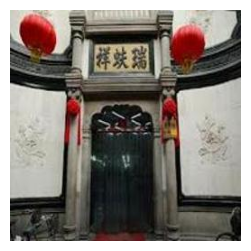

In [21]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image color_channels: {img_as_array.shape[2]}")
# Turn the image into an array

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.axis(False);

In [22]:
import torch
print("Number of CUDA devices available:", torch.cuda.device_count())

num_workers = os.cpu_count()
print(num_workers)

Number of CUDA devices available: 1
24


## Data augmentaion and normalizaion

In [23]:
transforms_train, transforms_valid = data_setup.get_transforms()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


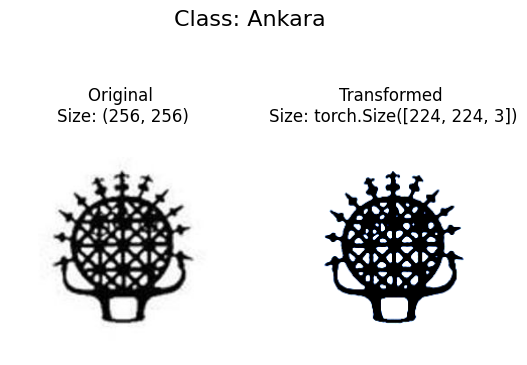

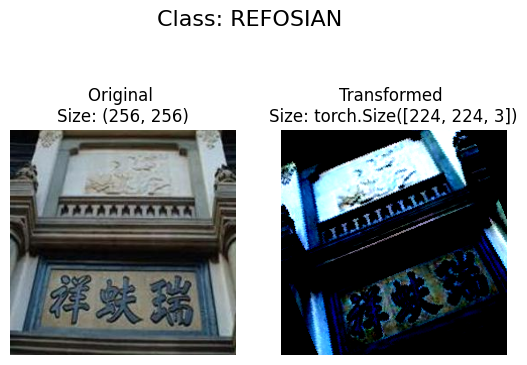

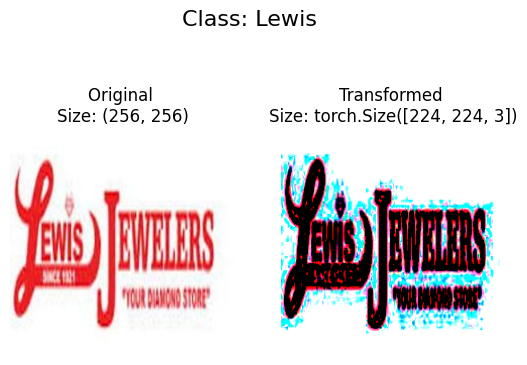

In [24]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=transforms_train, 
                        n=3)

## LOAD DATA

In [25]:
from sklearn.model_selection import KFold

train_dataset, valid_dataset, class_names = data_setup.get_datasets(data_dir=DATA_DIR, split_size=0.8)

In [26]:
print(len(train_dataset))
print(len(valid_dataset))

16450
4113


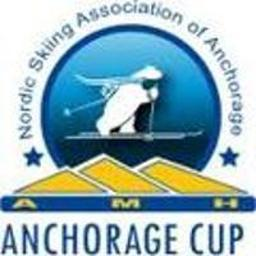

In [27]:
img, label = train_dataset[0]
img

In [28]:
class_names[label]

'Anchorage'

In [29]:
batch_size = 32
train_dataloader , valid_dataloader = data_setup.get_dataloaders(train_dataset, valid_dataset, batch_size, 4)

print('Train dataset size:', len(train_dataset))
print('Valid dataset size:', len(valid_dataset))
#print('Class names:', class_names)

num_classes = len(class_names)
print('Class numbers:', num_classes)
print()
print('Train dataloader size (number of batches):', len(train_dataloader))
print('Valid dataloader size (number of batches):', len(valid_dataloader))
print('Train dataset size:', len(train_dataloader.dataset))
print('Valid dataset size::', len(valid_dataloader.dataset))

Train dataset size: 16450
Valid dataset size: 4113
Class numbers: 287

Train dataloader size (number of batches): 515
Valid dataloader size (number of batches): 129
Train dataset size: 16450
Valid dataset size:: 4113


#  Visualize data after transformation

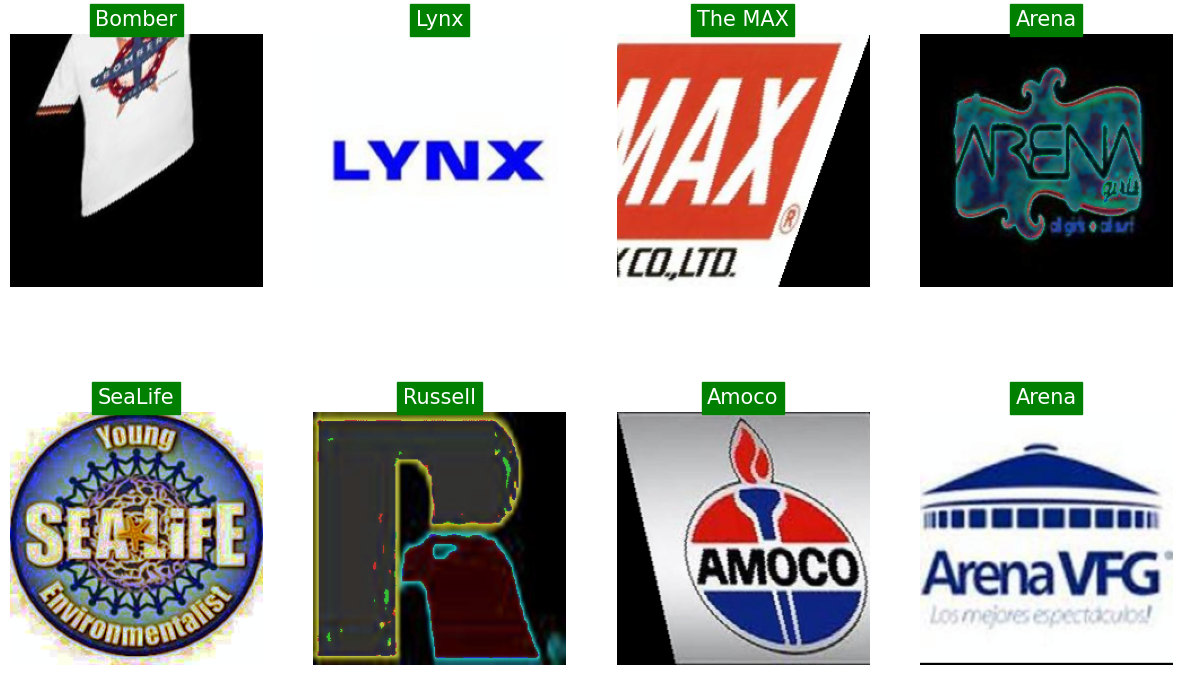

In [15]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(train_dataloader)
inputs, classes = next(iterator)
def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)

plt.show()

## Load pre-trained ResNet-18 model 

In [49]:
model = models.efficientnet_b7(pretrained=True)

In [47]:
model = models.vgg16(pretrained=True)

In [6]:
model.__class__

torchvision.models.vgg.VGG

In [50]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [10]:
for params in model.parameters():
    params.requires_grad = False

In [13]:
for param in model.features[28].parameters():
        param.requires_grad = True
for param in model.features[26].parameters():
        param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

In [14]:
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

features.0.weight - requires_grad: False
features.0.bias - requires_grad: False
features.2.weight - requires_grad: False
features.2.bias - requires_grad: False
features.5.weight - requires_grad: False
features.5.bias - requires_grad: False
features.7.weight - requires_grad: False
features.7.bias - requires_grad: False
features.10.weight - requires_grad: False
features.10.bias - requires_grad: False
features.12.weight - requires_grad: False
features.12.bias - requires_grad: False
features.14.weight - requires_grad: False
features.14.bias - requires_grad: False
features.17.weight - requires_grad: False
features.17.bias - requires_grad: False
features.19.weight - requires_grad: False
features.19.bias - requires_grad: False
features.21.weight - requires_grad: False
features.21.bias - requires_grad: False
features.24.weight - requires_grad: False
features.24.bias - requires_grad: False
features.26.weight - requires_grad: True
features.26.bias - requires_grad: True
features.28.weight - requi

In [114]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Computation device: cuda:0
138,357,544 total parameters.
134,260,544 training parameters.


In [105]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [104]:
for params in model.parameters():
    params.requires_grad = False

In [57]:
num_features = model.classifier[1].in_features

model.classifier[1] = nn.Linear(in_features=num_features, out_features=num_classes)

In [106]:
for param in model.features[8].parameters():
        param.requires_grad = True
for param in model.features[7].parameters():
        param.requires_grad = True

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Computation device: cuda:0
4,375,195 total parameters.
1,497,039 training parameters.


In [67]:
for name, child in model.features.named_children():
    for i in [7, 8]:
        for param in self.model.features[i].parameters():
            param.requires_grad = True

NameError: name 'self' is not defined

In [34]:
class Vgg16(nn.Module):
    def __init__(self, num_classes, pretrained=True, fine_tune=True):
        super(Vgg16, self).__init__()
        self.model = models.vgg16(pretrained=pretrained)
        # Remove the original fully connected layer
        num_features = self.model.classifier[0].in_features
        self.model.classifier[0] = nn.Linear(num_features, num_classes)


        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of in_features: {num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in self.model.parameters():
                params.requires_grad = True
        else:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        for params in self.model.parameters():
                params.requires_grad = False
        for i in [26, 28]:
            for param in self.model.features[i].parameters():
                param.requires_grad = True
        for param in self.model.classifier.parameters():
            param.requires_grad = True    

In [41]:
model = Vgg16(num_classes=num_classes, pretrained=True, fine_tune=False)

Model: Vgg16
[INFO]: Number of in_features: 25088
[INFO]: Freezing hidden layers...


In [42]:
for name, param in model.named_children():
    print(f"name: {name}, parm: ")

name: model, parm: 


In [40]:
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

model.features.0.weight - requires_grad: True
model.features.0.bias - requires_grad: True
model.features.2.weight - requires_grad: True
model.features.2.bias - requires_grad: True
model.features.5.weight - requires_grad: True
model.features.5.bias - requires_grad: True
model.features.7.weight - requires_grad: True
model.features.7.bias - requires_grad: True
model.features.10.weight - requires_grad: True
model.features.10.bias - requires_grad: True
model.features.12.weight - requires_grad: True
model.features.12.bias - requires_grad: True
model.features.14.weight - requires_grad: True
model.features.14.bias - requires_grad: True
model.features.17.weight - requires_grad: True
model.features.17.bias - requires_grad: True
model.features.19.weight - requires_grad: True
model.features.19.bias - requires_grad: True
model.features.21.weight - requires_grad: True
model.features.21.bias - requires_grad: True
model.features.24.weight - requires_grad: True
model.features.24.bias - requires_grad: T

In [20]:
NUM_EPOCHS = 100
SAVE_MODEL_TO = 'models'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
lr = 0.0001 
# I can use other optimizers like adam 
optimizer = optim.Adam(model.parameters(), lr=lr)# Use all parameters
scheduler = ExponentialLR(optimizer, gamma=0.9)
# Optimizers to compare ##TODO
optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9),
    'Adam': optim.Adam(model.parameters(), lr=0.0001),
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.0001)
    # Add any other optimizers you want to compare
}

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

cuda:0


## Train the model on custom data 

In [21]:
# Create directory name
directory_name = create_directory_name()
target_dir = f'{SAVE_MODEL_TO}/{directory_name}'

start_time = time.time()
results = engine.train_valid(model=model, 
                       train_dataloader= train_dataloader,
                       valid_dataloader=valid_dataloader,
                      optimizer=optimizer,
                      save_Model_to=target_dir,
                      epochs=NUM_EPOCHS, device=device,
                      loss_fn=loss_fn)
save_model(model=results[1], target_dir=target_dir, model_name='efficientnet_last.pth')
time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}%'.format(results[0]['best_acc']))

Processed::   0%|          | 0/100 [00:00<?, ?it/s]
Looked at 0/16330 samples.
Looked at 2400/16330 samples.
Looked at 4800/16330 samples.
Looked at 7200/16330 samples.
Looked at 9600/16330 samples.
Looked at 12000/16330 samples.
Looked at 14400/16330 samples.
.............
[INFO] Train Loss: 5.3723 | Acc: 7.1831% | Weighted F1: 4.8437
[INFO] Valid Loss: 4.8201 | Acc: 15.9687% | Weighted F1: 9.5989
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-05-12_14:38/resnet_best.pth
.............

Processed::   1%|          | 1/100 [02:10<3:35:14, 130.45s/it]
Looked at 0/16330 samples.
Looked at 2400/16330 samples.
Looked at 4800/16330 samples.
Looked at 7200/16330 samples.
Looked at 9600/16330 samples.
Looked at 12000/16330 samples.
Looked at 14400/16330 samples.
.............
[INFO] Train Loss: 4.5567 | Acc: 18.3221% | Weighted F1: 12.5895
[INFO] Valid Loss: 4.1851 | Acc: 22.7039% | Weighted F1: 16.4077
[INFO] Improvement-Detected, Best model updated
[INFO] 

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(32,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 286]                 --
├─Sequential: 1-1                                       [32, 1408, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    │    └─MBConv: 3-5                                 [32, 16, 112, 112]        (612)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-6                        

## Ploting

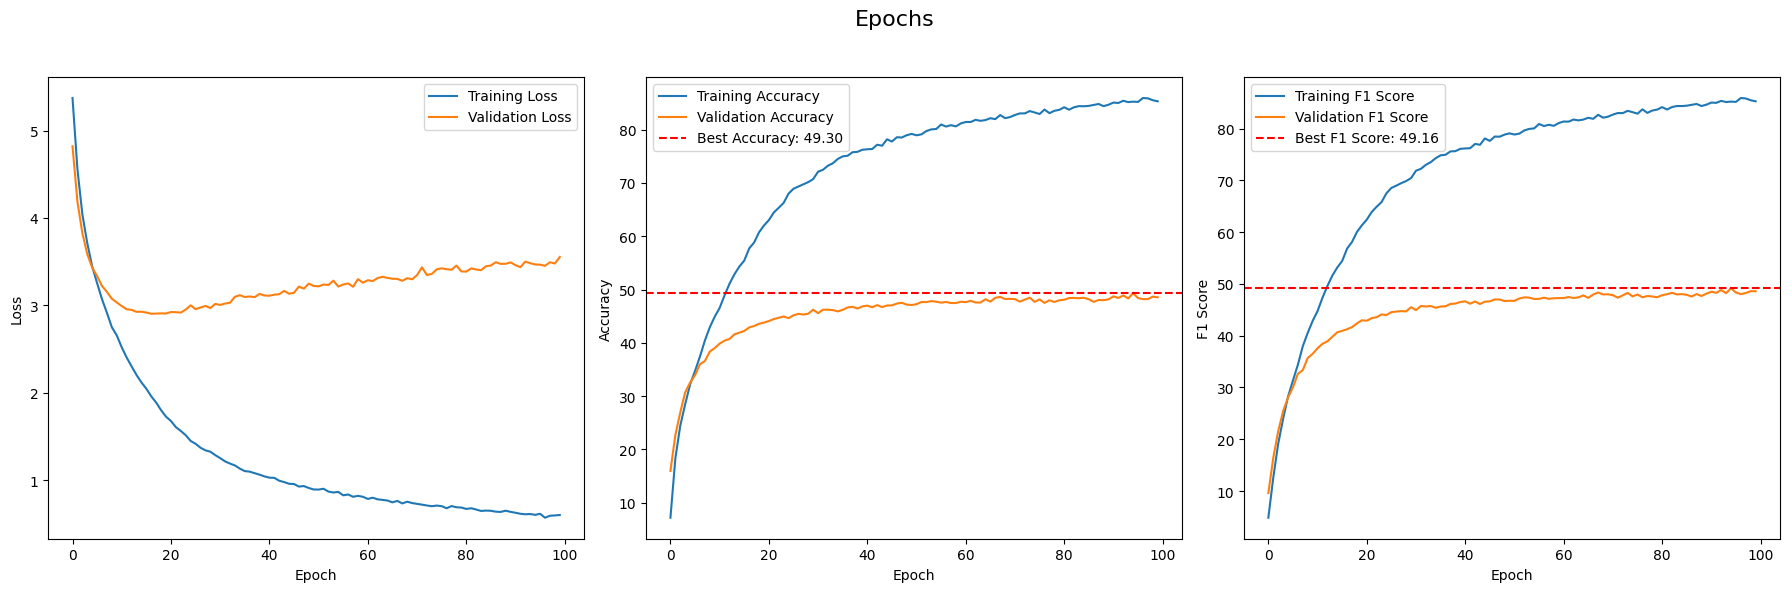

In [23]:
from utilities import visual
settings = { 'num_epochs': NUM_EPOCHS, 'batch_size':batch_size,
            'criterion': 'CrossEntropyLoss', 
             'optimizer': 'Adam', 'lr': lr,
}

title = 'Epochs'
visual.plot_results(results[0], target_dir, title)

In [24]:
import json
with open(f'{target_dir}/settings.json', 'w') as file:
    json.dump(settings, file)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]
y_pred = []
y_true = []
history_val = engine.valid_model(model, valid_dataloader, loss_fn, device)
        # Append result
y_pred.extend(history_val[2])
y_true.extend(history_val[3])

[INFO] Valid Loss: 3.5528 | Acc: 48.5427% | Weighted F1: 48.5899


In [26]:
print('Weighted F1: {:.4f}'.format(history_val[4]))

Weighted F1: 48.5899


In [27]:
print("Accuracy on Validation set: ", accuracy_score(y_true, y_pred))
classificationReport = classification_report(y_true, y_pred)
with open(f'{target_dir}/classificationReport.txt', 'w') as file:
    file.write(f'Classification report:\n {classificationReport}')
    file.close()
    
print('Classification report: \n', classificationReport)

Accuracy on Validation set:  0.48542738182708794
Classification report: 
               precision    recall  f1-score   support

           0       0.17      0.14      0.15        14
           1       0.83      0.56      0.67        18
           2       0.52      0.78      0.62        18
           3       0.13      0.33      0.19         6
           4       0.74      0.74      0.74        19
           5       0.40      0.67      0.50         6
           6       0.64      0.58      0.61        12
           7       0.78      0.78      0.78        18
           8       0.70      0.88      0.78        16
           9       0.33      0.53      0.41        15
          10       0.29      0.33      0.31        12
          11       0.70      0.70      0.70        20
          12       0.22      0.29      0.25         7
          13       0.10      0.14      0.11        14
          14       1.00      1.00      1.00        13
          15       0.27      0.27      0.27        11
       

Confusion matrix: 
 [[ 2  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  7]]


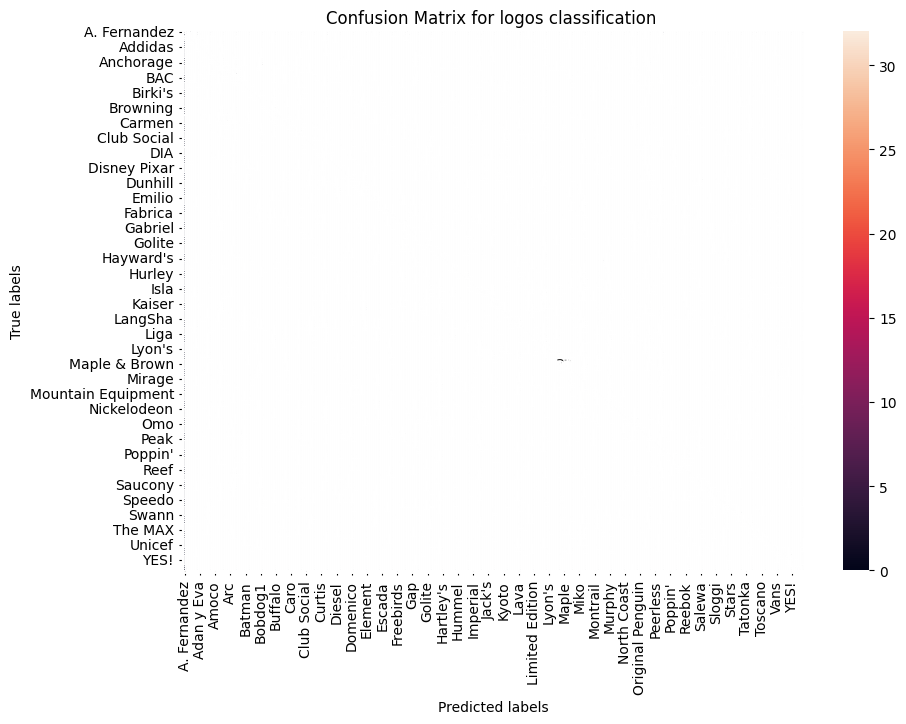

In [28]:
# Build confusion matrix
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for logos classification ")
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(f'{target_dir}/Confusion_Matrix.png')
plt.show()

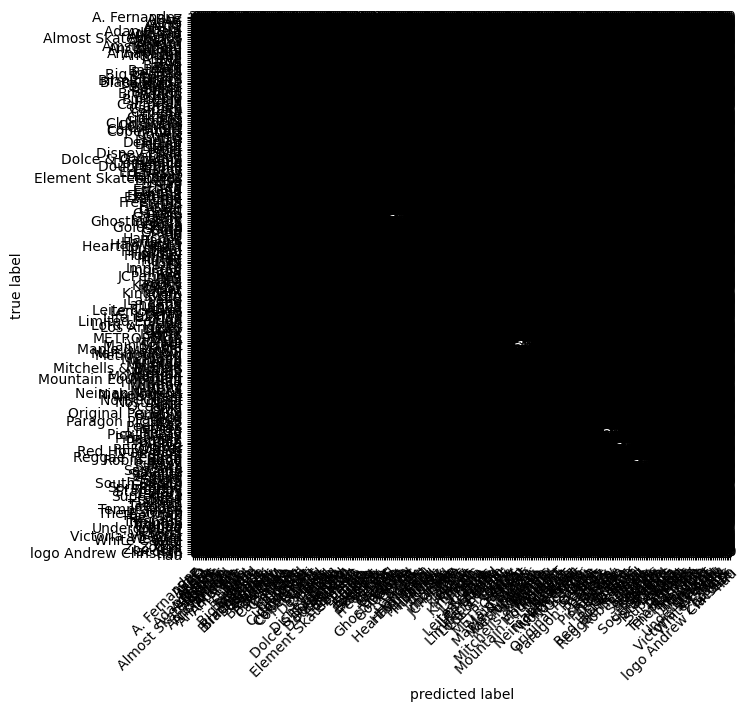

In [29]:
y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred, target=y_true)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

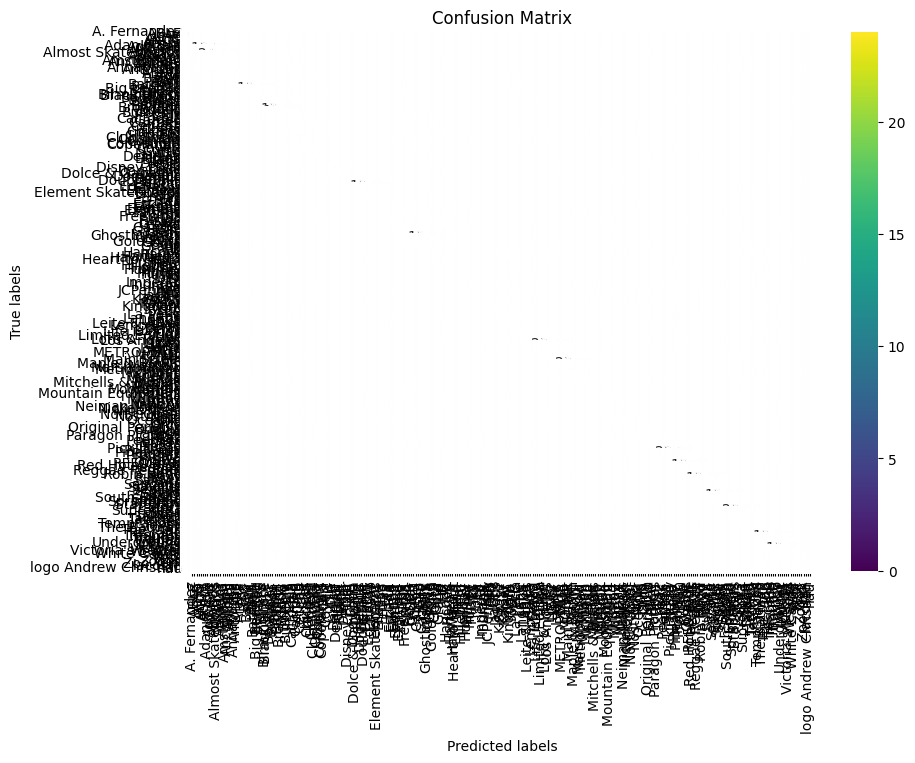

In [85]:
import seaborn as sns
confmat_normalized = confmat_tensor.numpy().astype('float') / confmat_tensor.numpy().sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confmat_tensor.numpy(), annot=True, ax=ax, cmap='viridis', fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90) 
ax.set_yticklabels(class_names)
plt.show()


# Load Saved Model

In [92]:
import torch
from torchvision import models, transforms
from PIL import Image

model = Resnet50(num_classes=num_classes)

model.load_state_dict(torch.load(f'{target_dir}/resnet_best.pth'))
model.eval()


### USE MODEL OR NEW_MODEL 
# Create a new model and adjust its final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Linear(new_model.fc.in_features, num_classes),
    nn.Sigmoid()
)
# Correctly copy the weights and biases from the loaded model to the new model
#new_model.fc[0].weight.data = model.fc[0].weight.data.clone()
#new_model.fc[0].bias.data = model.fc[0].bias.data.clone()

## Clasification on unseen Image

In [106]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# Load and preprocess the unseen image
image_path = 'img/boeing_img000019_34_0.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [107]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]
print(f'The predicted class is: {predicted_class_name}')

The predicted class is: Amoco


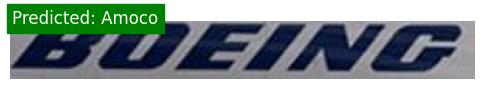

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [33]:
with open("Datasets/brands.txt", "r") as file:
    lines = file.readlines()

lines_upper = [line.upper() for line in lines]

unique_lines = set()
duplicate_lines = []

for line in lines_upper:
    if line in unique_lines:
        duplicate_lines.append(line)
    else:
        unique_lines.add(line)
print(f'{len(unique_lines)} Brands')

1090 Brands
